In [1]:
import io, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn import model_selection

import prepare

In [2]:
BASE_DIR = 'renamed'
DATA_OK = ['ok', 'near_ok_sonowechsel']
DATA_FEHLER = ['fehler_oel', 'fehler_leitungsversatz', 'fehler_terminversatz']

Einzeltest Tabelle zugversuch.csv

In [3]:
ok_dir = os.path.join(BASE_DIR, DATA_OK[0])
zugversuch = pd.read_csv(os.path.join(ok_dir, 'zugversuch.csv'), sep=';', decimal=',')
zugversuch.columns = ['nr', 'festigkeit']
zugversuch['nr'] = zugversuch.nr.astype('str')
zugversuch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   nr          200 non-null    object
 1   festigkeit  200 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.3+ KB


In [3]:
kurven = dict()
label = dict()
zugversuche = list()
# target labels for fail data
for idx, fname in enumerate(DATA_OK):
    label[fname] = idx
for idx, fname in enumerate(DATA_FEHLER):
    label[fname] = idx+2
for data_ok in DATA_OK:
    zugversuch = pd.read_csv(os.path.join(BASE_DIR, data_ok, 'zugversuch.csv'), sep=';', decimal=',')
    zugversuch.columns = ['nr', 'festigkeit']
    prefix = data_ok + '_'
    zugversuch['nr'] = zugversuch.nr.astype('str')
    zugversuch['key'] = prefix + zugversuch.nr
    zugversuch['label'] = label[data_ok]
    prepare.read_kurven(os.path.join(BASE_DIR, data_ok), zugversuch, kurven, prefix)
    zugversuche.append(zugversuch)
for data_fehl in DATA_FEHLER:
    zugversuch = pd.read_csv(os.path.join(BASE_DIR, data_fehl, 'zugversuch.csv'), sep=';', decimal=',')
    prefix = data_fehl + '_'
    zugversuch.columns = ['nr', 'festigkeit']
    zugversuch['nr'] = zugversuch.nr.astype('str')
    zugversuch['key'] = prefix + zugversuch.nr
    zugversuch['label'] = label[data_fehl]
    prepare.read_kurven(os.path.join(BASE_DIR, data_fehl), zugversuch, kurven, prefix)
    zugversuche.append(zugversuch)
zugversuche = pd.concat(zugversuche, ignore_index=True)


count 200 rows 1407...1650
count 100 rows 1582...1759
count 100 rows 1052...1434
count 100 rows 1716...2403
count 100 rows 1702...2092


Debugausgabe

In [4]:
zugversuche

,nr,festigkeit,key,label
0,1569,2600.000000,ok_1569,0
1,1570,2750.000000,ok_1570,0
2,1571,2770.000000,ok_1571,0
3,1572,2660.000000,ok_1572,0
4,1573,2810.000000,ok_1573,0
...,...,...,...,...
595,2505,1479.522827,fehler_terminversatz_2505,4
596,2506,2085.117920,fehler_terminversatz_2506,4
597,2507,2237.231201,fehler_terminversatz_2507,4
598,2508,2406.469482,fehler_terminversatz_2508,4


In [8]:
versuche_train, versuche_test = model_selection.train_test_split(zugversuche, test_size=0.2)

In [9]:
versuche_train

,nr,festigkeit,key,label
256,2985,2794.992920,near_ok_sonowechsel_2985,1
100,1669,2690.000000,ok_1669,0
294,3023,2527.995605,near_ok_sonowechsel_3023,1
193,1762,2940.000000,ok_1762,0
582,2492,2094.564941,fehler_terminversatz_2492,4
...,...,...,...,...
58,1627,3040.000000,ok_1627,0
487,2597,2498.555664,fehler_leitungsversatz_2597,3
23,1592,2790.000000,ok_1592,0
153,1722,2880.000000,ok_1722,0


In [10]:
X_train = prepare.concat_data(versuche_train, kurven, 800, 10)
label_train = versuche_train.label.values
festigkeit_train = versuche_train.festigkeit.values
print(X_train.shape, label_train.shape)
print(X_train.max(axis=(0,1)))
#festigkeit_train

(480, 80, 3) (480,)
[3.63044e+03 6.26972e+02 3.31001e+00]


In [11]:
X_test = prepare.concat_data(versuche_test, kurven, 800, 10)
label_test = versuche_test.label.values
festigkeit_test = versuche_test.festigkeit.values
print(X_test.shape)
print(X_test.max(axis=(0,1)))
#festigkeit_train

(120, 80, 3)
[3.53933e+03 6.25019e+02 3.41000e+00]


Skalieren Trainingsdaten

In [12]:
tsMaxScale = prepare.TsMaxScaler()
X_train_scaled = tsMaxScale.fit_transform(X_train)

Skalieren Testdaten

In [13]:
X_test_scaled = tsMaxScale.transform(X_test)

In [14]:
def class_curves(X, ax, y, field):
    color = ['black', 'blue', 'red', 'green', 'cyan']
    ti = np.arange(0, X.shape[1]) # Zeitschritte
    for i in range(X.shape[0]):
        #print(X[i,:,ax])
        plt.plot(ti, X[i,:,ax], c=color[y[i]], linewidth=0.5, alpha=0.5)
    handles = [
        matplotlib.lines.Line2D([0], [0], color='black', label='ok'),
        matplotlib.lines.Line2D([0], [0], color='blue', label='ok_wechsel'),
        matplotlib.lines.Line2D([0], [0], color='red', label='oel'),
        matplotlib.lines.Line2D([0], [0], color='green', label='leitung'),
        matplotlib.lines.Line2D([0], [0], color='cyan', label='termin'),
    ]
    plt.legend(handles=handles)

In [15]:
X_train[:10,:,:], label_train[:10]

(array([[[0.00000e+00, 0.00000e+00, 0.00000e+00],
         [0.00000e+00, 3.84045e+02, 6.99997e-02],
         [6.03732e+02, 3.19102e+02, 4.59999e-01],
         ...,
         [1.94227e+03, 5.91571e+02, 1.72000e+00],
         [1.95692e+03, 5.71795e+02, 1.72000e+00],
         [1.94472e+03, 5.93524e+02, 1.73000e+00]],
 
        [[0.00000e+00, 0.00000e+00, 0.00000e+00],
         [1.99896e+02, 3.86242e+02, 6.99997e-02],
         [8.22169e+02, 3.17148e+02, 4.70001e-01],
         ...,
         [2.38990e+03, 5.63738e+02, 1.73000e+00],
         [2.33070e+03, 5.75701e+02, 1.74000e+00],
         [2.39235e+03, 5.59832e+02, 1.74000e+00]],
 
        [[0.00000e+00, 0.00000e+00, 0.00000e+00],
         [0.00000e+00, 3.54503e+02, 8.00018e-02],
         [6.55423e+02, 3.17148e+02, 5.20004e-01],
         ...,
         [1.88257e+03, 5.50066e+02, 1.78000e+00],
         [1.98145e+03, 6.11347e+02, 1.79000e+00],
         [1.88257e+03, 5.48112e+02, 1.79000e+00]],
 
        ...,
 
        [[0.00000e+00, 0.00000e+00

In [16]:
X_train.shape, label_train.shape

((480, 80, 3), (480,))

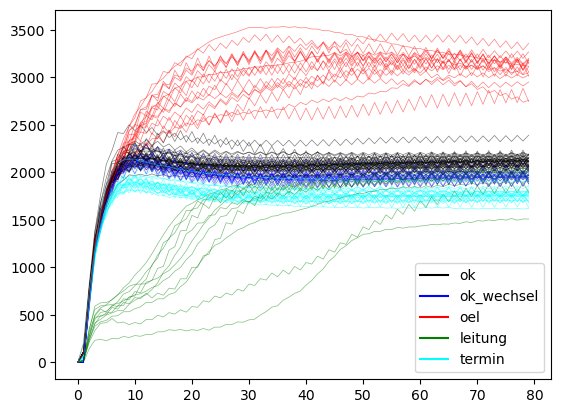

In [17]:
class_curves(X_train[:100,:,:], 0, label_train[:100], 'power')
plt.savefig('subsample_label_power.png')

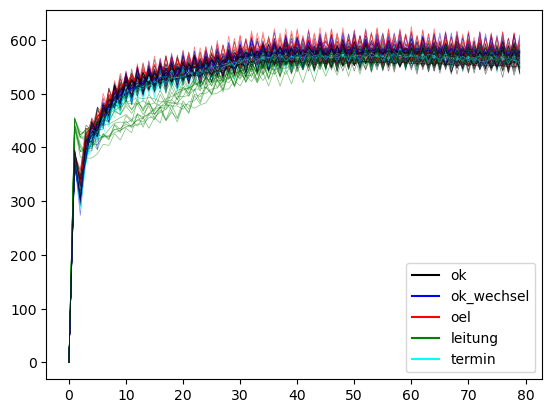

In [15]:
class_curves(X_train[:100,:,:], 1, label_train[:100], 'force')
plt.savefig('subsample_label_force.png')

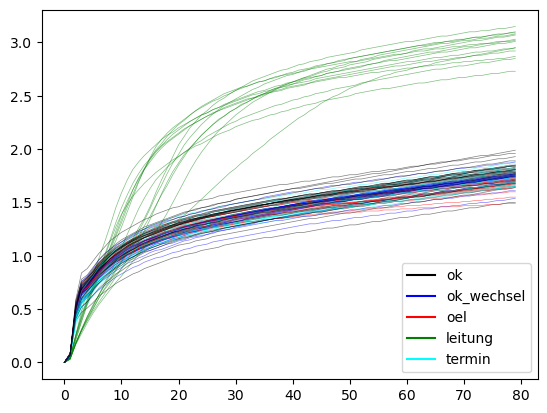

In [16]:
class_curves(X_train[:100,:,:], 2, label_train[:100], 'dist')
plt.savefig('subsample_label_dist.png')

In [18]:
def zug_curves(X, axis, y, field):
    fig, ax = plt.subplots()
    max_y = np.max(y)
    print(max_y)
    cmap = matplotlib.colormaps['rainbow']
    norm = matplotlib.colors.Normalize(0, max_y)
    ti = np.arange(X.shape[1])
    for i in range(X.shape[0]):
        color = cmap(y[i]/max_y)
        plt.plot(ti, X[i,:,axis], c=color, alpha=0.5, linewidth=0.5) #marker[m], c=color)
    plt.title(f'Zugfestigkeit bzgl. {field}')
    plt.xlabel('ms')
    plt.ylabel(field)
    #plt.legend(handles=handles)
    plt.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm), orientation='vertical', ax=ax, label='Zugfestigkeit')

2970.0


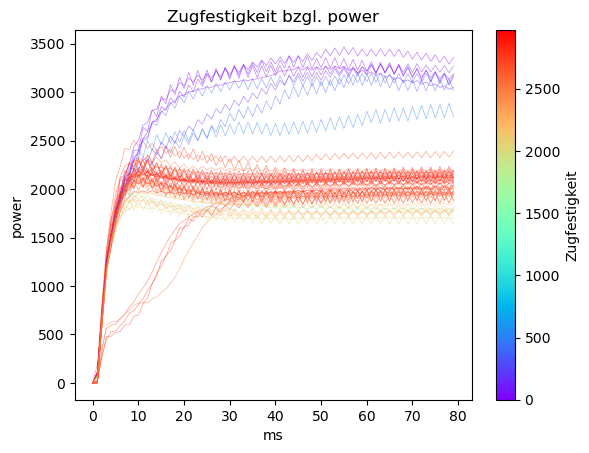

In [19]:
zug_curves(X_train[:50,:,:], 0, festigkeit_train[:50], 'power')
plt.savefig('subsample_zug_power.png')

3080.0


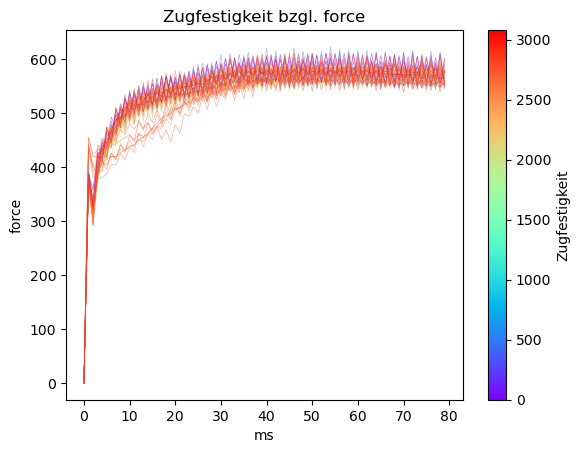

In [19]:
zug_curves(X_train[:50,:,:], 1, festigkeit_train[:50], 'force')
plt.savefig('subsample_zug_force.png')

3080.0


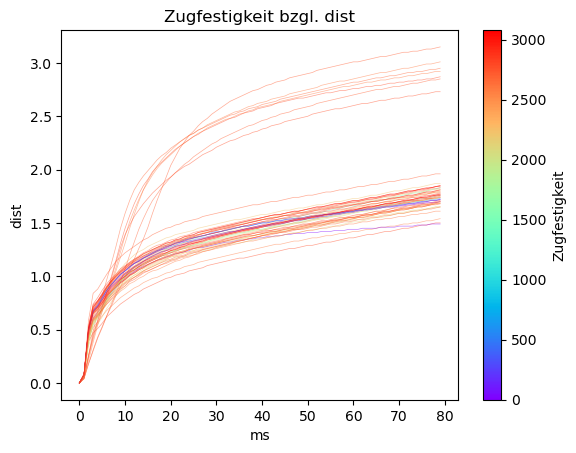

In [20]:
zug_curves(X_train[:50,:,:], 2, festigkeit_train[:50], 'dist')
plt.savefig('subsample_zug_dist.png')

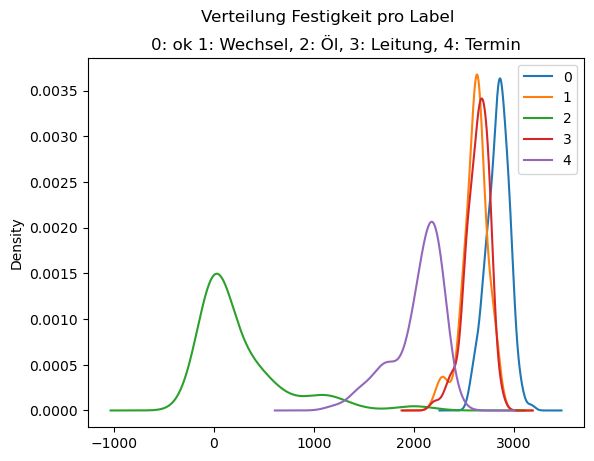

In [21]:
plt.figure()
versuche_train.groupby('label').festigkeit.plot(kind='density', legend=True)
plt.suptitle('Verteilung Festigkeit pro Label')
plt.title('0: ok 1: Wechsel, 2: Öl, 3: Leitung, 4: Termin')
plt.savefig('festigkeit_per_label.png')